# Euclid AAS 247 Workshop -- 2b. Galaxy Spectra

## Learning Goals

By the end of this tutorial, you will: 
- Download the spectrum of z=1.2-1.5 galaxies
- Search for interesting emission lines in that spectrum
- Bonus -- Overplot the interesting emission lines

## Introduction

Euclid launched in July 2023 as a European Space Agency (ESA) mission with involvement by NASA. The primary science goals of Euclid are to better understand the composition and evolution of the dark Universe. The Euclid mission is providing space-based imaging and spectroscopy as well as supporting ground-based imaging to achieve these primary goals. These data will be archived by multiple global repositories, including IRSA, where they will support transformational work in many areas of astrophysics.

Euclid Quick Release 1 (Q1) consists of consists of ~30 TB of imaging, spectroscopy, and catalogs covering four non-contiguous fields: Euclid Deep Field North (22.9 sq deg), Euclid Deep Field Fornax (12.1 sq deg), Euclid Deep Field South (28.1 sq deg), and LDN1641.

This exercise notebook gives you the opportunity to look at the spectrum of an interesting z=1.2-1.5 galaxies. You will join the MER and photo-z catalogs to find the galaxies, download and inspect a spectrum of one of the galaxies, and use the SPE catalog to follow up any interesting looking emission lines in the spectrum. 

## Imports

In [ ]:
# Uncomment the next line to install dependencies if needed.
# !pip install numpy 'astropy>=5.3' matplotlib 'astroquery>=0.4.10' 'sep>=1.4' fsspec

In [111]:
import re

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

from astropy.coordinates import SkyCoord
from astropy.table import QTable
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.utils.data import download_file
from astropy.visualization import ImageNormalize, PercentileInterval, AsinhStretch,  ZScaleInterval, SquaredStretch
from astropy.wcs import WCS
from astropy import units as u
from astropy.visualization import quantity_support

from astroquery.ipac.irsa import Irsa
import sep

import pandas as pd

In [112]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [113]:
# ## Set a longer timeout (default is 60 seconds)
Irsa.TIMEOUT = 300  # 5 minutes

# Euclid Q1 Galaxy Spectra

## 1. Determine which of the z=1.2 to 1.5 galaxies has spectra

Helpful notebooks -- 1b_Catalog_Access, 2a_Nearby_Galaxy_Morphology

Join the Euclid PHZ catalog ('Euclid Q1 PHZ Photo-z Catalog') and the Euclid MER catalog ('euclid_q1_mer_catalogue') on "object_id" for galaxies between z= 1.2 and 1.5 ('phz_median').

Use the joined catalog to find which of the galaxies has spectra ('has_spectrum').

Sort the query by brightest galaxy.

In [114]:
Irsa.list_catalogs(filter='euclid')

{'euclid_q1_mer_catalogue': 'Euclid Q1 MER Catalog',
 'euclid_q1_mer_morphology': 'Euclid Q1 MER Morphology',
 'euclid_q1_mer_cutouts': 'Euclid Q1 MER Cutouts',
 'euclid_q1_phz_photo_z': 'Euclid Q1 PHZ Photo-z Catalog',
 'euclid_q1_phz_star_sed': 'Euclid Q1 PHZ Star SED Catalog',
 'euclid_q1_phz_galaxy_sed': 'Euclid Q1 PHZ Galaxy SED Catalog',
 'euclid_q1_phz_classification': 'Euclid Q1 PHZ Classification Catalog',
 'euclid_q1_phz_qso_physical_parameters': 'Euclid Q1 PHZ QSO Physical Parameters Catalog',
 'euclid_q1_phz_nir_physical_parameters': 'Euclid Q1 PHZ NIR Physical Parameters Catalog',
 'euclid_q1_phz_star_template': 'Euclid Q1 PHZ Star Template Catalog',
 'euclid_q1_spectro_zcatalog_spe_quality': 'Euclid Q1 SPE Redshift Catalog - Quality',
 'euclid_q1_spectro_zcatalog_spe_classification': 'Euclid Q1 SPE Redshift Catalog - Classification',
 'euclid_q1_spectro_zcatalog_spe_galaxy_candidates': 'Euclid Q1 SPE Redshift Catalog - Galaxy Candidates',
 'euclid_q1_spectro_zcatalog_spe_

In [115]:
table_mer = 'euclid_q1_mer_catalogue'
table_phz= 'euclid_q1_phz_photo_z'

In [116]:
columns_info_mer = Irsa.list_columns(catalog=table_mer)
columns_info_mer

{'flux_g_ext_hsc_templfit': 'Gext HSC band source template fitting flux (TPHOT measurement)',
 'flux_z_ext_hsc_templfit': 'Zext HSC band source template fitting flux (TPHOT measurement)',
 'fluxerr_y_templfit': 'NIR Y band source template fitting flux error (TPHOT measurement)',
 'fluxerr_j_templfit': 'NIR J band source template fitting flux error (TPHOT measurement)',
 'fluxerr_h_templfit': 'NIR H band source template fitting flux error (TPHOT measurement)',
 'fluxerr_u_ext_decam_templfit': 'Uext DECam band source template fitting flux error (TPHOT measurement)',
 'fluxerr_g_ext_decam_templfit': 'Gext DECam band source template fitting flux error (TPHOT measurement)',
 'fluxerr_r_ext_decam_templfit': 'Rext DECam band source template fitting flux error (TPHOT measurement)',
 'fluxerr_i_ext_decam_templfit': 'Iext DECam band source template fitting flux error (TPHOT measurement)',
 'fluxerr_z_ext_decam_templfit': 'Zext DECam band source template fitting flux error (TPHOT measurement)',
 

In [117]:
## Search the photo-z catalog to find the brightest galaxies between z=1.2 and 1.5 that have spectra
    # phz.phz_median >1.2

adql_join = f"""
SELECT TOP 10 
    mer.ra, 
    mer.dec, 
    mer.tileid, 
    mer.has_spectrum,
    phz.object_id,
    phz.phz_median, 
    phz.phz_classification, 
    phz.flux_vis_unif
FROM {table_mer} AS mer
JOIN {table_phz} AS phz
    ON mer.object_id = phz.object_id
WHERE 
    phz.phz_median BETWEEN 1.2 AND 1.5
    AND phz.phz_classification = 2
    AND mer.has_spectrum=1
"""

## Run the query
result_join = Irsa.query_tap(adql_join).to_table()
#####################

In [118]:
result_join

ra,dec,tileid,has_spectrum,object_id,phz_median,phz_classification,flux_vis_unif
deg,deg,,,,,,uJy
float64,float64,int64,int64,int64,float32,int64,float64
271.30553199,66.41767624,102159488,1,2713055319664176762,1.460000038,2,0.9520317197
271.62776970,66.42718245,102159488,1,2716277696664271824,1.220000029,2,1.025833821
271.11144197,66.43158189,102159488,1,2711114419664315818,1.340000033,2,0.8496809741
271.28650521,66.43242294,102159488,1,2712865052664324229,1.289999962,2,1.533442616
272.17931938,66.43289721,102159488,1,2721793193664328972,1.289999962,2,0.7936804602
271.93504696,66.34851949,102159488,1,2719350469663485194,1.25999999,2,0.226335614
272.11791021,66.35233068,102159488,1,2721179102663523306,1.200000048,2,1.595022773
272.28194211,66.35306940,102159488,1,2722819421663530694,1.389999986,2,2.779879785


## 2. Search for the spectrum of the brightest galaxy 

Helpful notebooks -- 1c_Spectra_Access, 2a_Nearby_Galaxy_Morphology

Use the Euclid spectral catalog ('Euclid Q1 Object ID to Spectral File Association Table') to find the spectrum of an interesting bright galaxy.

In [119]:
Irsa.list_catalogs(filter='euclid')

{'euclid_q1_mer_catalogue': 'Euclid Q1 MER Catalog',
 'euclid_q1_mer_morphology': 'Euclid Q1 MER Morphology',
 'euclid_q1_mer_cutouts': 'Euclid Q1 MER Cutouts',
 'euclid_q1_phz_photo_z': 'Euclid Q1 PHZ Photo-z Catalog',
 'euclid_q1_phz_star_sed': 'Euclid Q1 PHZ Star SED Catalog',
 'euclid_q1_phz_galaxy_sed': 'Euclid Q1 PHZ Galaxy SED Catalog',
 'euclid_q1_phz_classification': 'Euclid Q1 PHZ Classification Catalog',
 'euclid_q1_phz_qso_physical_parameters': 'Euclid Q1 PHZ QSO Physical Parameters Catalog',
 'euclid_q1_phz_nir_physical_parameters': 'Euclid Q1 PHZ NIR Physical Parameters Catalog',
 'euclid_q1_phz_star_template': 'Euclid Q1 PHZ Star Template Catalog',
 'euclid_q1_spectro_zcatalog_spe_quality': 'Euclid Q1 SPE Redshift Catalog - Quality',
 'euclid_q1_spectro_zcatalog_spe_classification': 'Euclid Q1 SPE Redshift Catalog - Classification',
 'euclid_q1_spectro_zcatalog_spe_galaxy_candidates': 'Euclid Q1 SPE Redshift Catalog - Galaxy Candidates',
 'euclid_q1_spectro_zcatalog_spe_

In [120]:
table_1dspectra = 'euclid.objectid_spectrafile_association_q1'

In [121]:
columns_info = Irsa.list_columns(catalog=table_1dspectra)
print(len(columns_info))

7


In [122]:
columns_info

{'objectid': 'Euclid Object ID',
 'tileid': 'Euclid Tile ID',
 'path': 'Relative path to combined spectrum file containing spectrum for objectid',
 'hdu': 'HDU of combined spectrum file containing spectrum for objectid',
 'obs_publisher_did': 'VO identifier',
 'bandpass_name': 'Bandpass name',
 'label': 'Label'}

In [123]:
obj_id = result_join['object_id'][4]

In [124]:
adql_object = f"SELECT * FROM {table_1dspectra} WHERE objectid = {obj_id}"

# Pull the data on this particular galaxy
result = Irsa.query_tap(adql_object).to_table()

In [125]:
result

objectid,tileid,path,hdu,obs_publisher_did,bandpass_name,label
int64,int64,object,int64,object,object,object
2721793193664328972,102159488,api/spectrumdm/convert/euclid/q1/SIR/102159488/EUC_SIR_W-COMBSPEC_102159488_2024-11-05T16:04:40.540136Z.fits?dataset_id=euclid_combspec&hdu=2151,2151,ivo://ipac.irsa/euclid_sir_combined?102159488/2721793193664328972,RGS,2721793193664328972 co-added spectrum


In [126]:
spectrum_path = f"https://irsa.ipac.caltech.edu/{result['path'][0]}"
spectrum_path


# path = download_file(spectrum_path, cache=True, timeout=60)

'https://irsa.ipac.caltech.edu/api/spectrumdm/convert/euclid/q1/SIR/102159488/EUC_SIR_W-COMBSPEC_102159488_2024-11-05T16:04:40.540136Z.fits?dataset_id=euclid_combspec&hdu=2151'

## 3. Download the spectrum

Helpful notebooks -- 1c_Spectra_Access, 2a_Nearby_Galaxy_Morphology

Use the Euclid spectral catalog ('Euclid Q1 Object ID to Spectral File Association Table') to download the spectrum of an interesting nearby galaxy.

In [127]:
spectrum = QTable.read(spectrum_path)

In [128]:
spectrum

WAVELENGTH,SIGNAL,MASK,QUALITY,VAR,NDITH,UNCERTAINTY
Angstrom,1e-16 erg / (Angstrom s cm2),,,1e-32 erg2 / (Angstrom2 s2 cm4),,1e-16 erg / (Angstrom s cm2)
float32,float32,int32,float32,float32,int32,float32
11900.0,0.0,1,0.0,0.0,0,0.0
11913.400390625,0.0,1,0.0,0.0,0,0.0
11926.7998046875,0.0,1,0.0,0.0,0,0.0
11940.2001953125,0.24977649748325348,66,0.87117183,0.05651247128844261,2,0.23772351443767548
11953.599609375,0.31883564591407776,72,0.95601475,0.010821724310517311,2,0.10402751713991165
11967.0,0.005051235668361187,64,0.848404,0.0039405361749231815,4,0.0627736896276474
11980.400390625,0.13972723484039307,66,0.7367489,0.0020982848946005106,4,0.045807041227817535
11993.7998046875,0.01110418513417244,64,0.9540542,0.0011782188666984439,3,0.034325193613767624


## 4. Plot the extracted spectrum

Helpful notebooks -- 1c_Spectra_Access

Plot the spectrum to inspect it for any interesting emission lines. The "WAVELENGTH" and "SIGNAL" are the important columns.

As shown in 1c_Spectra_Access, use "quantity_support()" to automatically the axis units for the plots.

In [129]:
quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x168ee7040>

Text(0.5, 1.0, 'Object ID 2721793193664328972')

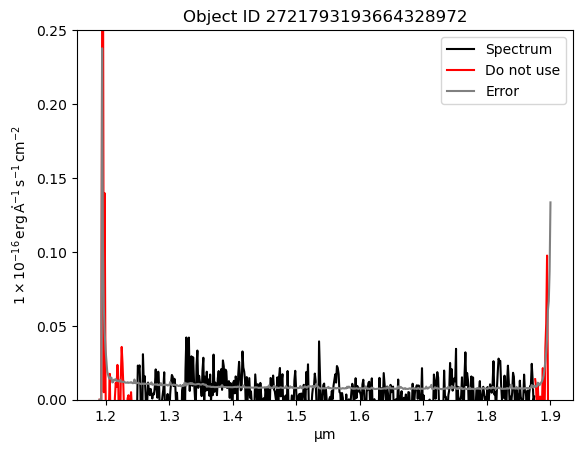

In [130]:
bad_mask = (spectrum['MASK'].value % 2 == 1) | (spectrum['MASK'].value >= 64)

plt.plot(spectrum['WAVELENGTH'].to(u.micron), np.ma.masked_where(bad_mask, spectrum['SIGNAL']), color='black', label='Spectrum')
plt.plot(spectrum['WAVELENGTH'], np.ma.masked_where(~bad_mask, spectrum['SIGNAL']), color='red', label='Do not use')
plt.plot(spectrum['WAVELENGTH'], np.sqrt(spectrum['VAR']), color='grey', label='Error')

plt.legend(loc='upper right')
plt.ylim(-0., 0.25)
plt.title(f'Object ID {obj_id}')

## 5. Use the SPE catalog to find any interesting emission lines

Helpful notebooks -- 5_Euclid_intro_SPE_catalog (https://caltech-ipac.github.io/irsa-tutorials/euclid-intro-spe-catalog/)

Search the SPE catalog for any strong emission lines in your galaxy spectrum.

In [84]:
Irsa.list_catalogs(filter='euclid')

{'euclid.tileid_association_q1': 'Euclid Q1 TILEID to Observation ID Association Table',
 'euclid.objectid_spectrafile_association_q1': 'Euclid Q1 Object ID to Spectral File Association Table',
 'euclid.observation_euclid_q1': 'Euclid Q1 CAOM Observation Table',
 'euclid.plane_euclid_q1': 'Euclid Q1 CAOM Plane Table',
 'euclid.artifact_euclid_q1': 'Euclid Q1 CAOM Artifact Table',
 'euclid_q1_mer_catalogue': 'Euclid Q1 MER Catalog',
 'euclid_q1_mer_morphology': 'Euclid Q1 MER Morphology',
 'euclid_q1_mer_cutouts': 'Euclid Q1 MER Cutouts',
 'euclid_q1_phz_photo_z': 'Euclid Q1 PHZ Photo-z Catalog',
 'euclid_q1_phz_star_sed': 'Euclid Q1 PHZ Star SED Catalog',
 'euclid_q1_phz_galaxy_sed': 'Euclid Q1 PHZ Galaxy SED Catalog',
 'euclid_q1_phz_classification': 'Euclid Q1 PHZ Classification Catalog',
 'euclid_q1_phz_qso_physical_parameters': 'Euclid Q1 PHZ QSO Physical Parameters Catalog',
 'euclid_q1_phz_nir_physical_parameters': 'Euclid Q1 PHZ NIR Physical Parameters Catalog',
 'euclid_q1_phz_

In [85]:
table_lines = 'euclid_q1_spe_lines_line_features'

In [86]:
adql_lines = f"""
SELECT TOP 10 
    mer.ra, 
    mer.dec, 
    mer.tileid, 
    mer.kron_radius,
    mer.semimajor_axis,
    mer.has_spectrum,
    lines.spe_line_snr_gf,
    lines.spe_line_snr_di, 
    lines.spe_line_name, 
    lines.spe_line_central_wl_gf,
    lines.spe_line_name
FROM {table_mer} AS mer
JOIN {table_lines} AS lines
    ON mer.object_id = lines.object_id
WHERE 
    mer.object_id = '2733541554685691496'
ORDER BY lines.spe_line_snr_gf DESC 
"""

## Run the query
adql_lines = Irsa.query_tap(adql_lines).to_table()
# #####################


In [87]:
adql_lines

ra,dec,tileid,kron_radius,semimajor_axis,has_spectrum,spe_line_snr_gf,spe_line_snr_di,spe_line_name,spe_line_central_wl_gf,spe_line_name2
deg,deg,,pix,pix,,,,,,
float64,float64,int64,float32,float32,int64,float32,float32,object,float32,object
273.35415550,68.56914965,102160611,9.00389576,1.286270857,1,6.416595459,4.960000038,Halpha,12520.45703,Halpha
273.35415550,68.56914965,102160611,9.00389576,1.286270857,1,6.416595459,-99,NII6585,12559.86035,NII6585
273.35415550,68.56914965,102160611,9.00389576,1.286270857,1,2.666759253,0,SII6718,12851.01855,SII6718
273.35415550,68.56914965,102160611,9.00389576,1.286270857,1,0,0,PaBeta,15363.19531,PaBeta
273.35415550,68.56914965,102160611,9.00389576,1.286270857,1,0,1.870000005,SIII9530,18205.5625,SIII9530
273.35415550,68.56914965,102160611,9.00389576,1.286270857,1,0,1.539999962,PaGamma,16945.87891,PaGamma
273.35415550,68.56914965,102160611,9.00389576,1.286270857,1,-99,-99,LyA,-99,LyA
273.35415550,68.56914965,102160611,9.00389576,1.286270857,1,-99,-99,SIII9068,-99,SIII9068


## About this Notebook

**Author(s)**: Tiffany Meshkat <br>
**Keyword(s)**: Euclid, Q1, AAS 247 Workshop <br>
**First published**: Dec 11, 2025 <br>
**Last updated**: Dec 11, 2025